In [1]:
import os
import torch
from fastai.torch_imports import resnet34
from fastai.transforms import tfms_from_model
from fastai.conv_learner import ConvnetBuilder
from fastai.core import V, VV, to_np, is_listy
from fastai.dataset import FilesIndexArrayDataset
from fastai.dataloader import DataLoader
from fastai.model import get_prediction
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
sz = 224
bs = 128
model = resnet34
model_weight_path = 'data/ternonter/models/224_all_ter_train_aug.h5'

In [3]:
trn_tfms, val_tfms = tfms_from_model(model, sz)
preprocess = val_tfms
model = ConvnetBuilder(model, 2, False, False, pretrained=False).model
sd = torch.load(model_weight_path)
model.load_state_dict(sd)
# self.model = self.model.cpu()
model.eval();

In [4]:
data_dir = 'data/ternonter/test2/'
flist = os.listdir(data_dir)
ds = FilesIndexArrayDataset(flist, np.ones(len(flist)), preprocess, path=data_dir)
dl = DataLoader(ds, batch_size=bs)

In [5]:
def get_predictions(model, dl):
    res = []
    for *x,y in dl: 
        res.append([get_prediction(to_np(model(*VV(x)))),to_np(y)])
    preds,targ = zip(*res)
    return np.concatenate(preds)

In [6]:
%%time

preds = get_predictions(model, dl)

CPU times: user 53.3 s, sys: 33.6 s, total: 1min 26s
Wall time: 25.1 s


In [7]:
np.exp(preds[:10,:])

array([[0.97951, 0.02049],
       [0.98188, 0.01812],
       [0.63144, 0.36856],
       [0.21507, 0.78493],
       [0.94727, 0.05273],
       [0.50983, 0.49017],
       [0.99924, 0.00076],
       [0.992  , 0.008  ],
       [0.99883, 0.00117],
       [0.99463, 0.00537]], dtype=float32)

In [10]:
y = np.ones((5645,1), dtype=np.int)
for ct, fname in enumerate(flist):
    if 'non' in fname:
        y[ct] = 0

In [11]:
np.sum(y)

633

In [12]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, np.exp(preds[:,1]), pos_label=1)
auc(fpr, tpr)

0.9092181922942599

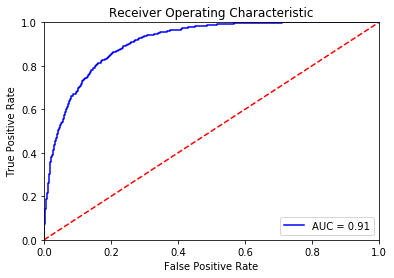

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr, tpr))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()